In [1]:
from utils import *

C:\Users\domin\Anaconda3\envs\tf2\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
GAME = 'Pendulum-v0'
env = gym.make(GAME)
S, A = env.observation_space.shape[0], env.action_space.shape[0]
print(S,A)
print(env.observation_space)
print(env.action_space)
print(env.reward_range)

3 1
Box(3,)
Box(1,)
(-inf, inf)


In [11]:
class ActorModel(tf.keras.Model):
    def __init__(self, S, A):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(50, 'relu')
        self.W2 = tf.keras.layers.Dense(A, 'tanh')
        self.call(np.ones([32,S],dtype=np.float32))
    
    def call(self, x): # [b,S]
        x = self.W1(x)
        return self.W2(x) * 2 # [-2;2]
    
create_Ann = lambda S,A: ActorModel(S,A)

In [ ]:
class Model(tf.keras.Model):
    def __init__(self, S, A):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(50, 'relu')
        self.W2 = tf.keras.layers.Dense(A)
        self.build((None,S))
    
    def call(self, x):
        x = self.W1(x)
        return self.W2(x)
    
create_nn = lambda S,A: Model(S,A)

In [33]:
create_Ann(S,A)(np.random.rand(5,3))

<tf.Tensor: id=1296, shape=(5, 1), dtype=float32, numpy=
array([[-0.64498454],
       [-0.13012135],
       [-0.27748793],
       [-0.07806314],
       [-0.3910868 ]], dtype=float32)>

In [16]:
class CriticModel(tf.keras.Model):
    def __init__(self, S, A):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(50, 'relu')
        self.W2 = tf.keras.layers.Dense(1)
        self.call(np.ones([32,S],dtype=np.float32), np.ones([32,A],dtype=np.float32))
    
    def call(self, s, a): # [b,S], [b,A]
        x = tf.concat([s,a], axis=1) # [b,S + A]
        x = self.W1(x) # [b,50]
        return tf.squeeze(self.W2(x)) # [b]
    
create_Cnn = lambda S,A: CriticModel(S,A)

In [55]:
class Agent():
    def __init__(self, num_states, num_actions, lr=[1e-4,1e-3], gamma=0.99, batch_size=128):
        self.S, self.A = num_states, num_actions
        self.y = gamma
        self.batch_size = batch_size
        self.COnn = create_Cnn(S,A) # critic online
        self.CTnn = create_Cnn(S,A) # critic target
        self.CTnn.set_weights( self.COnn.get_weights() )
        self.AOnn = create_Ann(S,A) # actor  online
        self.ATnn = create_Ann(S,A) # actor  target
        self.ATnn.set_weights( self.AOnn.get_weights() )
        self.Coptimizer = tf.optimizers.Adam(lr[0])
        self.Aoptimizer = tf.optimizers.Adam(lr[1])
        self.D = []
        
    def first_step(self, s, sdict): # [S]
        a = float(self.AOnn(s[None,:])[0]) # []
        self.s, self.a = s, a # save prev state + action
        return [a]
        
    def step(self, r, s, sdict): # [], [S]
        # append tuple to experience replay
        self.D.append([self.s, self.a, r, s, False]) # s, a, r, s', done
        if len(self.D) > self.batch_size: self.train_step(self.batch_size)
        A = self.AOnn(s[None,:]) # [1,A]
        a = float(A[0]) # []
        self.s, self.a = s, a # save previous state, action
        return [a]
    
    def last_step(self, r, sdict):
        self.D.append([self.s, self.a, r, self.s, True]) # s, a, r, s', done
        
    def train_step(self, b, tau=1e-3): # batch size, tau (target net update param)
        B = random.sample(self.D, b)
        S,A,R,Sn,Done = [np_map(lambda x: x[j], B) for j in range(5)] # all w/ shape [b] or [b,X]
        A = A if A.ndim != 1 else A[:,None]
        # update critic network
        A_actor = self.ATnn(Sn) # [b,A]
        Q_hat = R + self.y * (1-Done) * self.CTnn(Sn, A_actor) # [b]
        with tf.GradientTape() as tape:
            Q = self.COnn(S, A) # [b]
            value_loss = (Q-Q_hat)**2 # [b]
            loss = tf.reduce_mean(value_loss) # avg of all examples
        grads = tape.gradient(loss, self.COnn.trainable_variables)
        self.Coptimizer.apply_gradients(zip(grads, self.COnn.trainable_variables))
        # update actor network
        with tf.GradientTape() as tape:
            A = self.AOnn(S) # [b,A]
            policy_loss = -self.COnn(S,A) # [b] (maximize Q value)
            loss = tf.reduce_mean(policy_loss) # avg of all examples
        grads = tape.gradient(loss, self.AOnn.trainable_variables)
        self.Aoptimizer.apply_gradients(zip(grads, self.AOnn.trainable_variables))
        # update target networks
        w = [tau*o+(1-tau)*t for t,o in zip(self.ATnn.get_weights(), self.AOnn.get_weights())]
        self.ATnn.set_weights(w)
        w = [tau*o+(1-tau)*t for t,o in zip(self.CTnn.get_weights(), self.COnn.get_weights())]
        self.CTnn.set_weights(w)

In [56]:
agent_fn = lambda S,A,env_fn=None: Agent(S, A, gamma=0.99)

In [57]:
exp = Experiment(env, agent_fn(S,A))
df = exp.run(500, 1, name='')

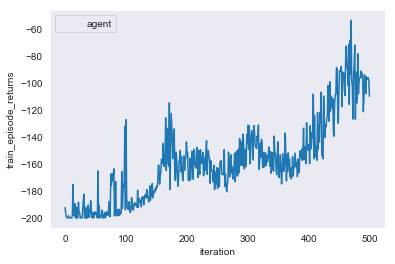

In [58]:
plot_df(df)

In [62]:
exp.show_play(1000)

200